<img src="header_profi.png" align="left"/>

# Exercise: Reinforcement Learning Moon Lander


The goal of this exercise is to work with reinforcement learning models and get a basic understanding of the topic. We will first develop controlers for the simple cart pole model and later for the lunar lander.
Neil Armstrong was the first to control a lunar lander in 1969. See a [video](https://youtu.be/xc1SzgGhMKc?t=520) about this masterpiece.
Luckily we do not have to go to the moon, but can do our experiments in simulation based on the [Openai gym](https://gym.openai.com/) software.


**Note**: openai gym is not well supported in anaconda. Please install gym in your conda environment using the following command:

```
pip install gym
pip install box2d box2d-kengz
```

**Note**: it can happend that the rendering window does not show up or close properly. In this case please check your environment and look for a solution and post it in the forum.


# Module imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import time
import tensorflow as tf

In [2]:
# suppress some warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=Warning)

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [3]:
print ( tf.__version__ ) 
print(gym.__version__)

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR )

2.11.0
0.21.0


# Very basic RL example

Run this basic cart pole example and find out how it works and what the basic functions of gym are. Document the code with python comments. Find out what the observation and action values mean.

In [4]:
env = gym.make('CartPole-v1')
env.reset()
cumulated_reward = 0
cumulated_reward_sum = 0
term_count = 1
for i in range(200):

    env.render()
    
    # pick random action from action space
    action = env.action_space.sample()
    
    # push action to environment and get back state, reward, done flag and more information
    observation, reward, done, info = env.step( action )
    
    # sum reward
    cumulated_reward += reward
    
    print( '\r', 'round: {} angle:{:.2f} position:{:.2f} rew:{} meancumrew:{} done:{}   action:{}     '.format(i,observation[2],observation[0],reward,cumulated_reward_sum/term_count,done,action), end='' )
    
    if done:
        env.reset()
        cumulated_reward_sum += cumulated_reward
        cumulated_reward = 0
        term_count += 1

    # some delay important for display to catch up
    time.sleep(0.1)
      
env.close()

 round: 199 angle:-0.03 position:0.04 rew:1.0 meancumrew:17.90909090909091 done:False   action:0       

# Implement a basic on-off control strategy

Before we go into advanced control strategies, lets attempt to control the cart pole with a simple on-off control strategy. Reading the [documentation](https://github.com/openai/gym/wiki/CartPole-v0) of this gym we find that it has two actions (push cart left = 0 and push cart right = 1). So, one idea could be to just look at the pole's angle and push the cart left if the pole leans to the left and vice versa. Give it a try.

In [5]:
env = gym.make('CartPole-v1')
env.reset()

cumulated_reward = 0
cumulated_reward_sum = 0
term_count = 1

pole_angle = 0

for i in range(200):

    env.render()
    
    # Result: implement your control strategy here
    if pole_angle < 0:
        action = 1
    else:
        action = 0

    observation, reward, done, info = env.step( action )
    cumulated_reward += reward
    pole_angle = observation[0]

    print( '\r', 'round: {} angle:{:.2f} position:{:.2f} rew:{} meancumrew:{} done:{}   action:{}     '.format(i,observation[2],observation[0],reward,cumulated_reward_sum/term_count,done,action), end='' )
    
    if done:
        env.reset()
        cumulated_reward_sum += cumulated_reward
        cumulated_reward = 0
        term_count += 1

    # some delay important for display to catch up
    time.sleep(0.1)
      
env.close()

 round: 199 angle:-0.05 position:-0.06 rew:1.0 meancumrew:26.666666666666668 done:False   action:1     

# DQN Solution to cart pole balancing

Now lets build a first version based on advanced RL technique, the Deep Q-Network. Here a neural network is trained to estimate the best action for a state based on the Q-learning concept.

The code is based on the work by Greg Surma and it can be found [here](https://github.com/gsurma/cartpole).


In [6]:
import random
from collections import deque
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import model_from_json

prefix = 'results/16_dqn_'

# hyperparameters from https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055

GAMMA = 0.98
LEARNING_RATE = 0.002
LEARNING_RATE_DECAY = 0.9990
MEMORY_SIZE = 1000000
BATCH_SIZE = 16
EXPLORATION_MAX = 0.75
EXPLORATION_MIN = 0.1
EXPLORATION_DECAY = 0.98
layout=[10,10]

class DQNControl:

    def __init__(self, observation_space, action_space,layout=[24,24],name='nona'):
        
        print ('building DQN model with observation space {} and action space {} layer {} name {}'.format(observation_space, action_space,layout,name) )
        
        self.exploration_rate = EXPLORATION_MAX
        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)
        self.name = name
        
        self.model = Sequential()
        self.model.add(Dense(layout[0], input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(layout[1], activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                        initial_learning_rate=LEARNING_RATE,
                        decay_steps=1000,
                        decay_rate=LEARNING_RATE_DECAY)        
        
        self.model.compile(loss="mse", optimizer=Adam(learning_rate=lr_schedule ))

        
    def save(self):
        modelName = prefix + self.name + "model.json"
        weightName = prefix + self.name + "model.h5"
        model_json = self.model.to_json()
        with open( modelName , "w") as json_file:
            json_file.write(model_json)
        # serialize weights to HDF5
        self.model.save_weights( weightName )
        print("saved model to disk as {} {}".format(modelName,weightName))

        
    def load(self):    
        modelName = prefix + self.name + "model.json"
        weightName = prefix + self.name + "model.h5"
        json_file = open(modelName, 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        self.model = model_from_json(loaded_model_json)
        self.model.load_weights(weightName)
        print("loaded model from disk")
        
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
        
    def action(self,state):
        q_values = self.model.predict(state,verbose=0)
        return np.argmax(q_values[0])
        
        
        
    def act(self, state):
        #
        # Task: what is the purpose of this if statement
        # Result: ....
        #
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)

        q_values = self.model.predict(state,verbose=0)
        
        #
        # Task: what is the idea behind this step (to come from value to action)?
        # Result: ....
        #
        return np.argmax(q_values[0])

    
    def experience_replay(self):
        
        if len(self.memory) < BATCH_SIZE:
            return
        
        batch = random.sample(self.memory, BATCH_SIZE)
        
        for state, action, reward, state_next, done in batch:
            
            q_update = reward
            if not done:
                #
                # Task: give an explanation for the formula of the update of the Q-value
                #
                q_update = (reward + GAMMA * np.amax( self.model.predict(state_next, verbose=0)[0] ) )
            
            q_values = self.model.predict(state,verbose=0)
            
            q_values[0][action] = q_update
            
            self.model.fit(state, q_values, verbose=0)
            
            
            
    def close_episode(self):
        #
        # Task: what is going on here?
        # Result: ...
        #
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)          

In [7]:
def trainDQN(env,episodes=50,layout=[24,24], name='nona', termination_reward=None, termination_runs=None, termination_runs_reward=None ):
    
    observation_space = env.observation_space.shape[0]
    action_space = env.action_space.n

    dqn_solver = DQNControl(observation_space, action_space,layout,name)
    
    history = []
    run = 0
    
    accumulated_reward = 0
    sliding_accumulated_reward = 0
    
    while run < episodes:
        
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        step = 0
        while True:
            
            step += 1
            
            #env.render()
            
            action = dqn_solver.act(state)
            
            state_next, reward, terminal, info = env.step(action)
            
            accumulated_reward += reward
            
            if not (termination_runs is None) and step > termination_runs:
                terminal = True
                if not (termination_runs_reward is None):
                    reward = termination_runs_reward
            else:
                if terminal and not (termination_reward is None):
                    reward = termination_reward
            
            state_next = np.reshape(state_next, [1, observation_space])
            
            dqn_solver.remember(state, action, reward, state_next, terminal)
            
            state = state_next
            
            if terminal:
                
                sliding_accumulated_reward = sliding_accumulated_reward * 0.9 + accumulated_reward * 0.1
                
                print ( '\r', 'episode: {}, exploration: {:.3f}, score: {} sliding score {}'.format(run,dqn_solver.exploration_rate,accumulated_reward,sliding_accumulated_reward), end='' )
                
                history.append([run,dqn_solver.exploration_rate,accumulated_reward,sliding_accumulated_reward,step])
                
                accumulated_reward = 0
                break
            
            dqn_solver.experience_replay()
        
        
        dqn_solver.close_episode()
        
        
        run += 1

    return dqn_solver,history

In [8]:
env = gym.make("CartPole-v1")

In [9]:
control,history = trainDQN(env=env,episodes=100,layout=layout,name='cartdqn',termination_reward=-200,termination_runs=100,termination_runs_reward=None)

building DQN model with observation space 4 and action space 2 layer [10, 10] name cartdqn
 episode: 0, exploration: 0.750, score: 12.0 sliding score 1.2000000000000002

2023-06-02 19:37:41.134504: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


 episode: 99, exploration: 0.101, score: 101.0 sliding score 100.77397859397044

In [10]:
env.close()

In [11]:
# Save model for later
control.save()

saved model to disk as results/16_dqn_cartdqnmodel.json results/16_dqn_cartdqnmodel.h5


In [12]:
df = pd.DataFrame(history)

<Axes: >

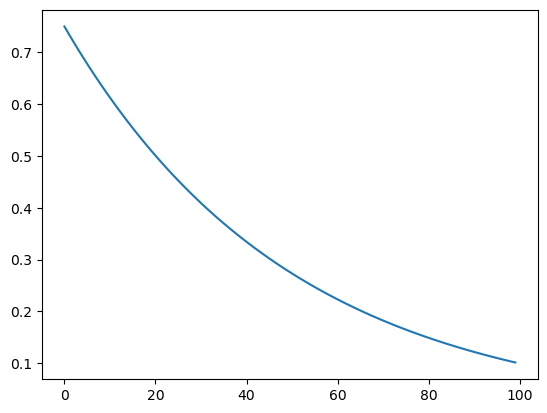

In [13]:
df[1].plot()

<Axes: >

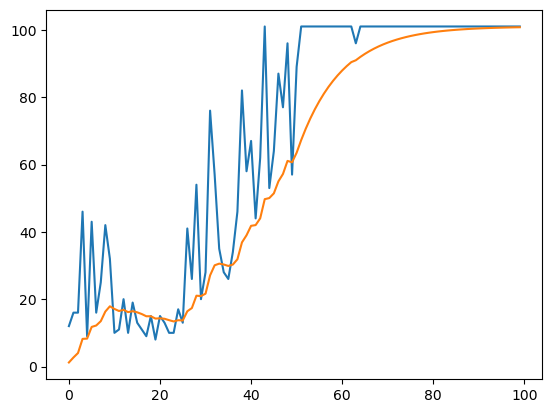

In [14]:
df[2].plot()
df[3].plot()

# Test the DQL control

In [ ]:
env = gym.make('CartPole-v1')
env.reset()

In [16]:
observation_space = env.observation_space.shape[0]
action_space = env.action_space.n
control = DQNControl(observation_space, action_space, name='cartdqn',layout=layout)
control.load()

state = env.reset()
cumulated_reward = 0

for i in range(100):
    env.render(mode='close')

    # Result: implement your control strategy here
    action = control.action( np.reshape(state, [1, observation_space]) )
    observation, reward, done, _ = env.step( action )
    
    cumulated_reward += reward
        
    print( '\r', 'round: {} angle:{:.2f} position:{:.2f} rew:{} cumrew:{} done:{}   action:{}     '.format(i,observation[2],observation[0],reward,cumulated_reward,done,action), end='' )
    
    if done:
        state = env.reset()
        cumulated_reward = 0

    # some delay important for display to catch up
    time.sleep(0.05)
      
env.close()

building DQN model with observation space 4 and action space 2 layer [10, 10] name cartdqn
loaded model from disk
 round: 99 angle:0.02 position:0.01 rew:1.0 cumrew:2.0 done:False   action:1       

# Using PPO for Cart Pole

In [4]:
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import os

In [5]:
# Parallel environments
vec_env = make_vec_env("CartPole-v1", n_envs=4)

In [6]:
model = PPO("MlpPolicy", vec_env, verbose=0)

In [7]:
model.learn(total_timesteps=25000)
model.save("ppo_cartpole")

In [8]:
del model # remove to demonstrate saving and loading

In [9]:
model = PPO.load("ppo_cartpole")

In [10]:
obs = vec_env.reset()
for episode in range(200):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = vec_env.step(action)
    vec_env.render("human")

# Lunar lander problem

How we are looking into the lunar lander problem. We reuse the DQN controller from above with different parameters. Play with this problem and get an understanding of the rewards. Configuration is taken from [2]. A general discussion about this approach was published in [1].

- [1] https://www.researchgate.net/publication/333145451_Deep_Q-Learning_on_Lunar_Lander_Game
- [2] https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055

In [5]:
env = make_vec_env("LunarLander-v2", n_envs=4)
env.reset()

array([[ 0.006 ,  1.4064,  0.6043, -0.1996, -0.0069, -0.1369,  0.    ,
         0.    ],
       [-0.0005,  1.4159, -0.0552,  0.2211,  0.0006,  0.0125,  0.    ,
         0.    ],
       [-0.0049,  1.4038, -0.4965, -0.3164,  0.0057,  0.1125,  0.    ,
         0.    ],
       [ 0.0027,  1.4099,  0.2729, -0.0452, -0.0031, -0.0618,  0.    ,
         0.    ]], dtype=float32)

In [6]:
models_dir = "results"

In [7]:
model = PPO('MlpPolicy', env, verbose=0)

In [8]:
TIMESTEPS = 10000
ITERATIONS = 10
for iteration in range(ITERATIONS):
    model.learn(total_timesteps=TIMESTEPS, reset_num_timesteps=False,log_interval=10)
    model.save(f"{models_dir}/lunar_ppo_{iteration}")

In [9]:
env.reset()

array([[-0.0016,  1.4141, -0.16  ,  0.1419,  0.0018,  0.0362,  0.    ,
         0.    ],
       [ 0.0073,  1.4053,  0.7397, -0.2483, -0.0085, -0.1676,  0.    ,
         0.    ],
       [ 0.0025,  1.4111,  0.2569,  0.008 , -0.0029, -0.0582,  0.    ,
         0.    ],
       [-0.003 ,  1.3988, -0.3061, -0.5404,  0.0035,  0.0693,  0.    ,
         0.    ]], dtype=float32)

In [10]:
model_path = f"{models_dir}/lunar_ppo_9.zip"
model = PPO.load(model_path, env=env)

In [ ]:
episodes = 2
for ep in range(episodes):
    obs = env.reset()

    action, _states = model.predict(obs)
    obs, rewards, done, info = env.step(action)
    
    while not done.any():
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action)
        env.render()

[1.0858 1.0473 0.0186 0.6178]
[ 1.0511  1.0673 -0.0244  0.564 ]
[1.0045 1.3619 1.8548 0.7135]
[ 1.5199  1.5746 -2.155   0.8719]
[ 1.8624  0.7289 -1.7835 -0.387 ]
[ 1.5846  0.6953 -0.6303 -1.323 ]
[ 2.0379  1.5834  0.2329 -1.9625]
[ 0.0539 -0.1829 -0.7614  1.8611]
[-0.9316  1.7661 -1.5245 -2.0338]
[-0.1835  0.5581  3.31   -0.3568]
[-1.2621 -1.3757  1.9417 -0.8497]
[-0.5813  0.5418  0.1739 -0.8311]
[-2.5008  0.2594 -0.9932 -1.1967]
[ 0.8124  0.0966 -1.7847 -2.6191]
[-1.3211 -1.7344  3.6411 -2.3242]
[-0.8076 -0.0474 -2.3138 -2.1621]
[-2.3157 -1.8434 -1.1268  0.2123]
[-2.2695 -0.725   2.4694  3.0903]
[ 1.0834 -0.9713 -1.7121  0.9626]
[-2.0686 -1.6736 -1.5157  1.597 ]
[ 1.5102 -0.0623 -2.2674 -0.1136]
[ 0.1738 -1.9124  2.9286 -2.2418]
[-0.3844 -0.4677 -1.9986 -2.0391]
[ 3.3856 -1.9469  3.7913 -0.0783]
[-0.299  -2.0493  0.7777 -0.9783]
[-2.0189 -0.0118  2.7103 -1.208 ]
[-0.7712  2.23    1.1646 -2.2869]
[ 0.7138 -1.7789 -1.1651 -2.0415]
[ 0.3446 -1.5288 -2.0076  3.4862]
[ 0.2181 -0.0094  3.19

[ 2.7416 -2.0494 -2.6769 -2.3372]
[-2.215  -2.391   3.2511  3.4921]
[ 2.3057 -2.6794 -2.5819  1.3782]
[ 3.9714 -2.6313 -2.5703 -2.8523]
[-2.4214  2.8832 -2.8173  2.6419]
[-1.2102  2.7183  0.3846 -2.2855]
[-1.8013  1.3824 -3.1255  2.6524]
[ 0.8597 -0.8492 -2.3226  0.6484]
[ 0.6496  1.4583 -2.2816  1.4149]
[ 0.4803 -2.6755  3.9307  3.1871]
[ 0.2281  1.9178 -1.9497  3.5685]
[ 2.148   0.0067  2.959  -2.3808]
[ 2.054  -0.1676 -2.4504 -2.458 ]
[ 1.265  -2.7334  0.3811 -0.8811]
[-0.3849  2.2296  1.8313 -0.6003]
[-2.2559 -2.8575  3.6093  2.0036]
[-2.2646 -0.1524 -1.6855 -2.2583]
[-2.6347  3.2228 -1.6051  2.2038]
[-1.2722 -2.7514  4.0909  2.5615]
[ 1.8728 -2.664  -1.3777 -2.8052]
[-2.7551 -2.2288 -2.0704 -2.8316]
[ 1.72    1.8632 -2.2991  3.0609]
[ 0.7655  2.5118  3.3626 -2.1579]
[-0.3295  0.9112  3.6954  2.6477]
[-1.21    1.6071  1.0493 -2.3472]
[ 1.8145  2.1167 -1.9392 -1.4446]
[ 0.5335  1.6983 -2.4888 -1.5076]
[-1.4226  0.1421  0.6528 -2.297 ]
[ 3.8107  2.0008 -1.5611  1.3692]
[-1.8817 -1.55

[-2.5065  0.1972  0.5424 -2.5175]
[ 2.2268 -1.6896  0.3431  1.7974]
[ 3.5771  0.4766 -0.4277 -2.3344]
[-2.3442  2.977   3.4206 -1.6018]
[-0.4927  0.2385 -2.5006 -2.1552]
[ 2.9249 -2.2625 -1.7129 -1.7169]
[-1.668   1.9516 -2.4163 -1.9657]
[ 2.2489 -2.1112 -1.8457  2.399 ]
[ 2.5895 -1.5937  2.1731 -2.4163]
[-1.488  -1.5985  0.8051 -2.0635]
[ 2.2968  4.962  -2.0861  2.8052]
[-1.6567 -1.7276  0.2508  3.358 ]
[-2.1453  3.6359  3.4085 -2.3754]
[-2.7085 -1.3142 -2.5678 -2.4181]
[ 0.2715 -1.5207  0.3112  2.2576]
[-0.7558  1.1498  3.0087  0.3406]
[-2.5814  3.4377  0.7268 -2.1149]
[-2.3496 -0.6078  1.4803  3.097 ]
[ 3.1622  0.0757  0.6655 -1.919 ]
[ 2.2092 -0.2094 -2.2576  3.4553]
[-2.449  -2.42    2.63    3.0024]
[ 3.6344  3.3452 -2.383   3.7539]
[ 3.2833 -1.9316  0.845   2.6925]
[1.3359 1.0963 1.4988 2.63  ]
[-1.1925 -2.0439  3.5284 -1.783 ]
[ 3.799  -1.8686  1.7901 -1.6163]
[1.4047 3.1542 1.127  1.1948]
[ 2.9057  3.1602  3.1985 -1.7467]
[-0.7617  0.73    1.177  -1.6441]
[-2.4133  3.3127 -2.11

[-0.8117 -2.4077  2.8422 -2.1309]
[ 1.9366  0.7507  2.3541 -0.6606]
[ 1.9781  3.0365  0.9195 -1.1981]
[-1.4336 -0.55   -0.1927 -1.9426]
[-2.026   0.7805 -2.4    -0.6359]
[ 2.1393 -2.4664 -0.4248  1.9482]
[2.0794 3.6975 4.5154 3.4489]
[-0.723   2.2971 -2.1347 -2.1192]
[ 2.1682 -2.4754  1.2117 -1.3134]
[ 1.4208 -2.3055 -1.3198 -1.3302]
[ 3.0119  2.1408 -2.0348 -1.7361]
[-1.8688  1.2769  4.0731 -1.5857]
[ 2.378   0.2333 -1.8169  3.3728]
[ 3.3573  1.1708  2.1424 -0.9141]
[ 1.0418 -2.1984 -1.6931  1.9367]
[-1.9495 -2.1466  0.2105  4.0906]
[ 0.7354  2.2351 -1.1025  3.2705]
[ 2.4475  1.6333  2.4896 -0.5996]
[-1.5947  2.6169  2.6519 -1.8239]
[-1.4498  2.4588 -1.705  -1.4505]
[ 3.1876 -2.1389  2.9588 -0.4015]
[-1.3635  2.3995  1.3828  4.0154]
[ 0.4722  2.0499 -1.1375 -1.3658]
[ 3.665  -0.1484 -0.0305 -0.3222]
[-0.4084  0.8521  0.8302  2.8463]
[ 1.5804 -2.0862 -1.5816  3.4338]
[ 1.8345  0.1668 -1.8163  1.143 ]
[1.4738 4.2638 4.3366 2.3838]
[ 2.7206 -1.9584 -1.1927  3.9407]
[ 3.154  -1.7839  1.06